In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.quantum_info import Operator

from penalty import *
from topology import *

key = random.PRNGKey(0)
from jax import custom_jvp, jvp, grad

# Helper functions

In [2]:
@jit
def box_angles(a):
    """Bring angles within range (-pi, pi)"""
    aright = a + jnp.pi
    aright = aright % (2*jnp.pi)
    a_center = aright - jnp.pi
    return a_center

def cz_count(angles, epsilon=1e-2):
    """Count how many angles in cp gates a close to identity, CNOT and generic."""
    count = 0
    for a in angles:
        if jnp.abs(a)<epsilon:
            count += 0
        elif jnp.abs(a-jnp.pi)<epsilon or jnp.abs(a+jnp.pi)<epsilon:
            count += 1
        else:
            count +=2
            
    return count

def TLB(n):
    return int((4**n-3*n-1)/4 + 1)


def random_pair(key, num_qubits):
    key, subkey = random.split(key)
    i, j = random.randint(key, shape=(2,), minval=0, maxval=num_qubits)
    if i==j:
        return random_pair(key, num_qubits)
    else:
        return int(i), int(j)

def random_placements(key, num_qubits, num_cz):
    *keys, _ = random.split(key, num=num_cz+1)
    return [random_pair(key, num_qubits) for key in keys]        

def random_special_unitary(key, num_qubits, num_cz):
    placements = {'free': random_placements(key, num_qubits, num_cz)}
    a = Ansatz(num_qubits, 'cz', placements)
    angles = random.uniform(key, shape=(a.num_angles, ), minval=0, maxval=2*jnp.pi)
    return a.unitary(angles), placements



# Benchamrks

In [71]:
placements = random_placements(random.PRNGKey(0), 3, 10)
a = Ansatz(3, 'cz', {'free': placements})
u_target  = unitary_group.rvs(8, random_state=42)

In [73]:
%%time
angles_history, loss_history = a.learn(u_target)

CPU times: user 10.7 s, sys: 197 ms, total: 10.9 s
Wall time: 10.1 s


# Test

In [114]:


u = unitary_group.rvs(2, random_state=0)

def plain_trace(a):
    tr = (rx_mat(a) * u.conj().T).sum()
    return jnp.abs(tr)**2

@custom_jvp
def shift_trace(a):
    tr = (rx_mat(a) * u.conj().T).sum()
    return jnp.abs(tr)**2

@shift_trace.defjvp
def shift_trace_jvp(primals, tangents):
    a, = primals
    b, = tangents
    
    tr = (rx_mat(a) * u.conj().T).sum()
    tr_s = (rx_mat(a+jnp.pi) * u.conj().T).sum()
    
    primal_out = jnp.abs(tr)**2
    tangent_out = (tr_s * tr.conj()).real * b
    
    return primal_out, tangent_out

In [134]:
a, = (1, )

In [135]:
a

1

In [128]:
def all_shifts(u, angles, s):
    n = len(angles)
    basis_shifts = jnp.identity(n)
    return vmap(lambda x: u(angles+x))(s*basis_shifts) 

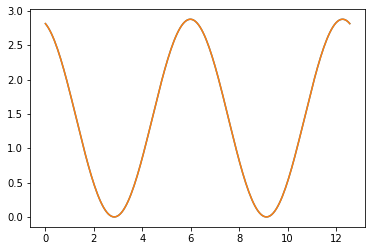

In [121]:
a_sweep = jnp.linspace(0, 4*jnp.pi, 200)
plt.plot(a_sweep, vmap(plain_trace)(a_sweep))
plt.plot(a_sweep, vmap(shift_trace)(a_sweep))

# Real test

In [10]:
a = Ansatz(5, 'cz', fill_layers(sequ_layer(5), 50))
u = a.unitary
v = unitary_group.rvs(2**5, random_state=14)
# a.circuit().draw()

In [11]:
angles = random.uniform(key, minval=0, maxval=2*jnp.pi, shape=(a.num_angles, ))

@jit
def plain_grad(angles):
    return grad(lambda a: trace2(u, v, a))(angles)

@jit
def shift_grad(angles):
    return grad(lambda a: shift_trace2(u, v, a))(angles)

In [12]:
%%time
pg = plain_grad(angles)

CPU times: user 23.5 s, sys: 26 ms, total: 23.6 s
Wall time: 23.6 s


In [13]:
%%time
sg = shift_grad(angles)

CPU times: user 6.54 s, sys: 7.71 ms, total: 6.55 s
Wall time: 6.55 s


In [14]:
jnp.allclose(pg, sg, rtol=1e-5, atol=1e-6)

DeviceArray(True, dtype=bool)

In [15]:
%timeit plain_grad(angles)

859 µs ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit shift_grad(angles)

59.1 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
